In [1]:
import os
import glob
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision import transforms


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/codespace/.local/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/codespace/.local/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/codespace/.local/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File "/home/codes

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



ImportError: numpy.core.multiarray failed to import

In [ ]:
class VisDrone(Dataset):
    def __init__(self, root):
        self.root = root
        self.image_files = sorted(glob.glob(os.path.join(root, "images", "*.jpg")))
        self.label_files = sorted(glob.glob(os.path.join(root, "annotations", "*.txt")))
        assert len(self.image_files) == len(self.label_files), "Number of images and labels must be the same"

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = self._load_image(idx)
        bboxes = self._load_annotations(idx)
        return image, bboxes, len(bboxes)
    
    def _load_image(self, idx):
        image = cv2.imread(self.image_files[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    
    def _load_annotations(self, idx):
        full_annotations = np.loadtxt(self.label_files[idx], delimiter=",", dtype=np.uint32)
        only_car_annotations = full_annotations[full_annotations[:, 5] == 4]
        bboxes = only_car_annotations[:, :4]
        return bboxes

In [ ]:
visdrone_categories = {
    1: "pedestrian",
    2: "people",
    3: "bicycle",
    4: "car",
    5: "van",
    6: "truck",
    7: "tricycle",
    8: "awning-tricycle",
    9: "bus",
    10: "motor",
}
visdrone = VisDrone("visdrone-dataset")

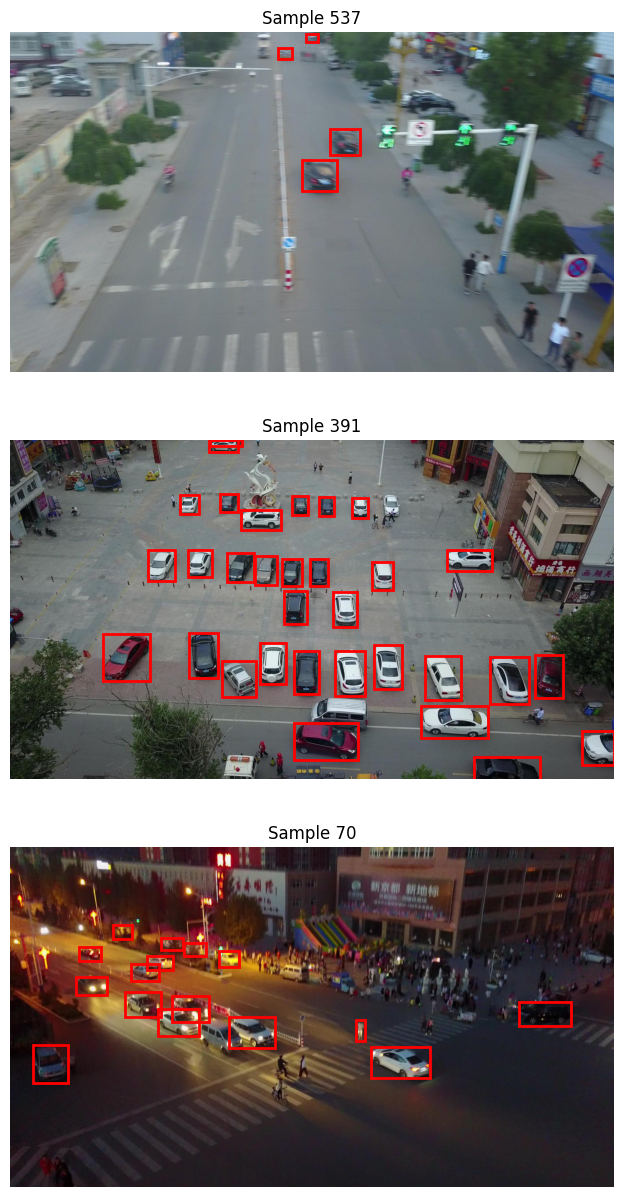

In [ ]:
num_samples = 3
fig, axes = plt.subplots(num_samples, 1, figsize=(15, 5*num_samples))    
src_indices = np.random.choice(len(visdrone), num_samples, replace=False)
for i, idx in enumerate(src_indices):
    src_patch, bboxes, num_obj = visdrone[idx]
    ax = axes[i] if num_samples > 1 else axes
    ax.imshow(src_patch)
    ax.set_title(f"Sample {idx}")
    for bbox in bboxes:
        x, y, w, h = bbox
        rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
    ax.axis('off')

In [ ]:
class ImageGenerator(Dataset):
    def __init__(self, dataset: Dataset, dataset_size: int, patch_size: tuple[int, int]):
        self.dataset = dataset
        self.dataset_size = dataset_size
        self.patch_size = patch_size

    def __len__(self):
        return self.dataset_size
    
    def __getitem__(self, idx: int):
        background = self._create_background()
        num_obj = np.random.randint(2, 8)
        image, bboxes = self._add_objects(background, num_obj)
        return image, bboxes, len(bboxes)

    def _add_objects(self, background:np.ndarray, num_obj:int) -> tuple[np.ndarray, np.ndarray]:
        result_image = background.copy()
        bg_h, bg_w = background.shape[:2]
        max_attempts = 10 * num_obj
        attempts = 0
        placed_boxes = []
        while len(placed_boxes) < num_obj and attempts < max_attempts:
            attempts += 1
            
            img_idx = np.random.choice(self.dataset_size)
            image, bboxes, num_bboxes = self.dataset[img_idx]
            
            if num_bboxes == 0:
                continue
            
            box_idx = np.random.choice(num_bboxes)
            x, y, w, h = bboxes[box_idx]
                
            car = image[y:y+h, x:x+w]
            
            scale = np.random.uniform(0.8, 1.2)
            new_w, new_h = int(w * scale), int(h * scale)
            
            if new_w > bg_w // 2 or new_h > bg_h // 2:
                continue

            if new_w > 0 and new_h > 0:
                car = cv2.resize(car, (new_w, new_h))
            else:
                continue
            
            max_x = bg_w - new_w
            max_y = bg_h - new_h
            
            if max_x <= 0 or max_y <= 0:
                continue
                
            pos_x = np.random.randint(0, max_x)
            pos_y = np.random.randint(0, max_y)
            
            new_box = np.array([pos_x, pos_y, new_w, new_h])
            
            overlap_ok = True
            for placed_box in placed_boxes:
                overlap_ratio = self._calculate_overlap(new_box, placed_box)
                if overlap_ratio > 0.5:
                    overlap_ok = False
                    break
            
            if not overlap_ok:
                continue
            
            result_image[pos_y:pos_y+new_h, pos_x:pos_x+new_w] = car
            
            placed_boxes.append(new_box)
        
        return result_image, np.array(placed_boxes)
     
    def _calculate_overlap(self, box1, box2):
        x1_1, y1_1, w1, h1 = box1
        x2_1, y2_1 = x1_1 + w1, y1_1 + h1
        
        x1_2, y1_2, w2, h2 = box2
        x2_2, y2_2 = x1_2 + w2, y1_2 + h2
        
        x_left = max(x1_1, x1_2)
        y_top = max(y1_1, y1_2)
        x_right = min(x2_1, x2_2)
        y_bottom = min(y2_1, y2_2)
        
        if x_right < x_left or y_bottom < y_top:
            return 0.0
        
        intersection_area = (x_right - x_left) * (y_bottom - y_top)
        
        box1_area = w1 * h1
        box2_area = w2 * h2
        
        smaller_area = min(box1_area, box2_area)
        if smaller_area == 0:
            return 0.0
            
        return intersection_area / smaller_area
    

    def _create_background(self):
        h, w = self.patch_size
        background = np.zeros((2 * h, 2 * w, 3), dtype=np.uint8)
        src_indices = np.random.choice(self.dataset_size, 4, replace=False)
        ref_indices = np.random.choice(self.dataset_size, 4, replace=False)
        for i, (src_idx, ref_idx) in enumerate(zip(src_indices, ref_indices)):
            src_patch, _, _ = self.dataset[src_idx]
            ref_patch, _, _ = self.dataset[ref_idx]

            src_patch = cv2.resize(src_patch, (w, h))
            ref_patch = cv2.resize(ref_patch, (w, h))

            src_patch = self._color_correction(src_patch, ref_patch)
            
            x, y = i % 2 * w, i // 2 * h
            background[y:y+h, x:x+w] = cv2.resize(src_patch, (w, h))
        return background
    
    def _color_correction(self, src: np.ndarray, ref: np.ndarray) -> np.ndarray:
        src = src.astype(float)
        ref = ref.astype(float)
        result = np.zeros_like(src)
        
        for i in range(3):
            source_mean = np.mean(src[:, :, i])
            source_std = np.std(src[:, :, i])
            target_mean = np.mean(ref[:, :, i])
            target_std = np.std(ref[:, :, i])
            
            if source_std > 1e-6:
                result[:, :, i] = (src[:, :, i] - source_mean) / source_std * target_std + target_mean
            else:
                result[:, :, i] = src[:, :, i]
        
        result = np.clip(result, 0, 255).astype(np.uint8)
        return result

In [ ]:
# Initialize the generator with visdrone dataset and set parameters
patch_size = (512, 512)
generator = ImageGenerator(visdrone, dataset_size=len(visdrone), patch_size=patch_size)

# Generate a sample image
gen_image, gen_bboxes, num_obj = generator[0]

# Create a figure with 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle(f"Generated Image with {num_obj} Objects", fontsize=16)

# Display original image
axes[0, 0].imshow(gen_image)
axes[0, 0].set_title("Generated Image")
axes[0, 0].axis('off')

# Display image with bounding boxes
axes[0, 1].imshow(gen_image)
axes[0, 1].set_title("Image with Bounding Boxes")
for bbox in gen_bboxes:
    x, y, w, h = bbox
    rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
    axes[0, 1].add_patch(rect)
axes[0, 1].axis('off')

# Display number of objects as a bar
axes[1, 0].bar(['Number of Objects'], [num_obj], color='blue')
axes[1, 0].set_title(f"Object Count: {num_obj}")
axes[1, 0].set_ylim(0, max(10, num_obj + 2))
axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

# Display histogram of the image
axes[1, 1].hist(gen_image.ravel(), bins=256, color='gray', alpha=0.7)
axes[1, 1].set_title("Image Histogram")
axes[1, 1].set_xlabel("Pixel Value")
axes[1, 1].set_ylabel("Frequency")
axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

ImportError: cannot import name 'ERR_IGNORE' from 'numpy.core.umath' (/opt/conda/lib/python3.12/site-packages/numpy/core/umath.py)